# Comparing image acquisition methods: spectral imaging vs variable bandpass filter (VBF) imaging.

**Instrument: Olympus FV 3000 Confocal laser scanning microscope

* Kane Toh

* 2020-03-06 


## Problem statement

In multi-labelling experiments where the specimen of interest is tagged with multiple fluorophores, a significant challenge faced in image acquisition is the task of discriminating between the emitted signals. This stems from the fact that the emission spectra of different fluorophores have significant degrees of overlap. This phenomenon is called `spectral bleed-through` and creates artifacts in imaging (Figure 1). A target fluorophore signal is reported to be present although in actuality, the signal is emitted from another fluorophore which has passed through the filter set reserved for the target fluorophore. 

One way to discriminate between fluorophores with overlapping emission spectra is to narrow the emission detection filter window such that within the detection range, the spillover 


### Problem statement:

Technically, we aim to effectively discriminate between the following 6 fluorophores in the zebrafish tailbud:

1. DAPI
2. Alexa fluor 488 (Sox2)
3. Alexa fluor 514 (Cyp26a1)
4. Alexa fluor 546 (Fgf8)
5. Alexa fluor 594 (Tbxta)
6. Alexa fluor 647 (Wnt8a)

Biologically,  


### Approach

To show that we are able to accurately detect the fluorescent signal, we compare two methods against each other in their ability to distinguish the Alexa fluor 488 and Alexa fluor 514 emission signal in a 2D image plane. We chose to focus on these two dyes as their emission spectra overlap substantially, such that conventional confocal imaging setups incur spectral bleed-through artefacts. 

1. In the spectral imaging approach, we first perform a lambda scan to scan the sample across (?) at (?) intervals. Then, the signal was linearly unmixed using the reference emission spectra for Alexa fluor 488 and 514. We used the reference spectra as we observed that there was no substantial difference in the reference dye spectra and the context-specific spectra that was obtained directly from our samples. 

2. In the VBF approach, we narrowed the detection window for both emission spectras to capture regions where spectral bleedthrough was minimal. 

## Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
sns.set(style="darkgrid")

import scipy.ndimage as ndi
from skimage.io import imread
from skimage import img_as_float

## Data

The zebrafish tailbud was stained for 5 different mRNAs with the version 3 hybridisation chain reaction (V3 HCR). Briefly, DNA probes were designed to bind specifically to target mRNAs of interest via complementary base pairing. These probes also contain a recognition sequence that flank the complementary sequence. Hairpins, which are conjugated to a particular Alexa dye, can bind to the recognition sequence and initiate a polymerisation reaction that occurs in a non-enzymatic fashion. The hairpin polymerisation serves to amplify the signal. Before imaging, the tailbud was stained with DAPI which intercalates with nuclear DNA, thus serving to highlight the nucleus. 

See https://dev.biologists.org/content/145/12/dev165753 from Choi et al., (2018) for more details of the V3 HCR method. 

In [2]:
# Reading in the files
filename_lambda = 'lambda_488_514.tif'
filename_vbf = 'vbf_488_514.tif'
img_lambda = imread(filename_lambda)
img_vbf = imread(filename_vbf)

# Separating channels
img_lambda_488 = img_lambda[0,:,:]
img_lambda_514 = img_lambda[1,:,:]
img_vbf_488 = img_vbf[0,:,:]
img_vbf_514 = img_vbf[1,:,:]

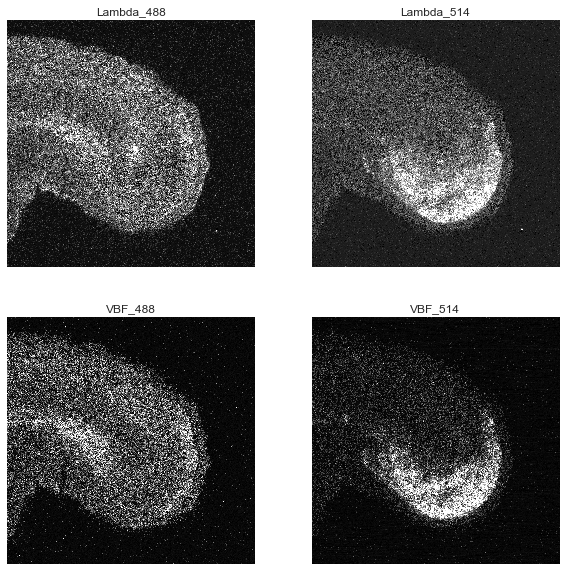

In [3]:
from skimage import exposure

def display_image(axis, img, cmap, title_name, setAxis = False):
    lwr_pct, upp_pct = np.percentile(img, (2, 98))
    adj_img = exposure.rescale_intensity(img, in_range = (lwr_pct, upp_pct), out_range = np.uint16) 
    axis.imshow(adj_img, cmap = cmap, interpolation = 'none')
    axis.set_title(title_name)
    if not setAxis:
        axis.set_axis_off()
    
fig, axes = plt.subplots(2,2, figsize = (10,10))
lambda_488, lambda_514, vbf_488, vbf_514 = axes.flatten()

display_image(lambda_488, img_lambda_488, "gray", "Lambda_488")
display_image(lambda_514, img_lambda_514, "gray", "Lambda_514")
display_image(vbf_488, img_vbf_488, "gray", "VBF_488")
display_image(vbf_514, img_vbf_514, "gray", "VBF_514")

plt.savefig('raw_lambda_vbf.png')

## Processing the image: analysing a region of interest 

In [4]:
from skimage import exposure
from skimage import filters 
from skimage.morphology import disk
from skimage.filters import threshold_otsu

def process_image(lwr_pct, upp_pct, img, rad, x_min, x_max, y_min, y_max):
    ### Contrast stretching to stretch histogram & also to span the uint16 dtype, followed by median filter with disk-shaped SEM to reduce bg.
    ### Image is then cropped to display ROI with signal for accurate Mander's overlap coeff and Pearson's R calc.
    lwr_pct, upp_pct = np.percentile(img, (lwr_pct, upp_pct))
    adj_img = exposure.rescale_intensity(img, in_range = (lwr_pct,upp_pct), out_range = np.uint16) 
    adj_img = filters.median(adj_img, disk(rad))
    adj_img = adj_img[x_min:x_max, y_min:y_max]
    raw_cropped = img[x_min:x_max, y_min:y_max]
    return adj_img, raw_cropped

# ROI for 488 channel
x_min_488 = 250
x_max_488 = 550
y_min_488 = 50
y_max_488 = 500

# ROI for 514 channel
x_min_514 = 400
x_max_514 = 700
y_min_514 = 300
y_max_514 = 750

adj_img_lambda_488, img_lambda_488_cropped_raw = process_image(2, 98, img_lambda_488, 4, x_min_488, x_max_488, y_min_488, y_max_488)
adj_img_lambda_514, img_lambda_514_cropped_raw  = process_image(2, 98, img_lambda_514, 4, x_min_514, x_max_514, y_min_514, y_max_514)
adj_img_vbf_488, img_vbf_488_cropped_raw = process_image(2, 98, img_vbf_488, 4, x_min_488, x_max_488, y_min_488, y_max_488)
adj_img_vbf_514, img_vbf_514_cropped_raw = process_image(2, 98, img_vbf_514, 4, x_min_514, x_max_514, y_min_514, y_max_514)


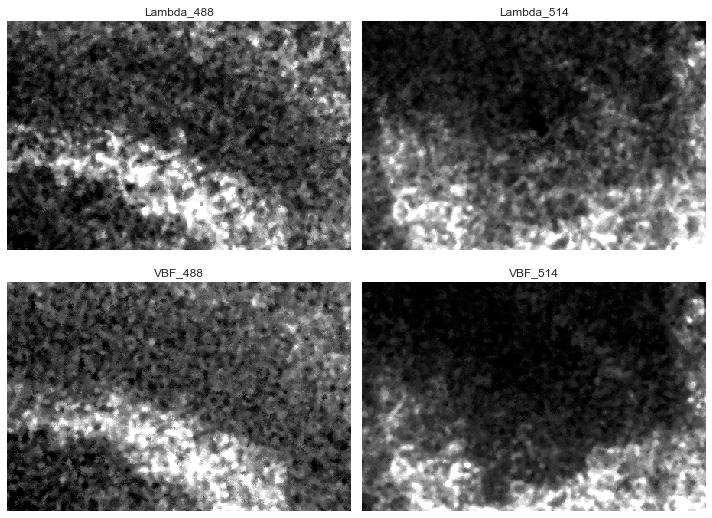

In [5]:
fig, axes = plt.subplots(2,2, figsize = (10,10))
lambda_488, lambda_514, vbf_488, vbf_514 = axes.flatten()

display_image(lambda_488, adj_img_lambda_488, "gray", "Lambda_488")
display_image(lambda_514, adj_img_lambda_514, "gray", "Lambda_514")
display_image(vbf_488, adj_img_vbf_488, "gray", "VBF_488")
display_image(vbf_514, adj_img_vbf_514, "gray", "VBF_514")

plt.tight_layout()
plt.subplots_adjust(top = 0.8)
plt.savefig('cropped_proc_lambda_vbf.png')

## Calculating Manders overlap coefficients (MOC)

M1_488 0.651306263770853
M2_488 0.8042599502487562
M1_514 0.7266647126222388
M2_514 0.8692506295222007


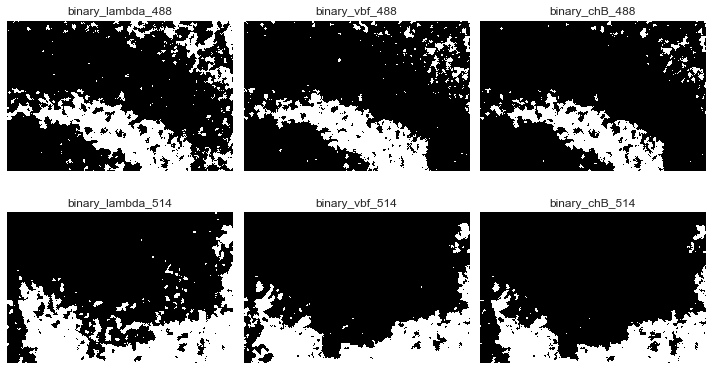

In [6]:
from skimage.filters import threshold_otsu

thr_lambda_488 = threshold_otsu(adj_img_lambda_488)
thr_vbf_488 = threshold_otsu(adj_img_vbf_488)
thr_lambda_514 = threshold_otsu(adj_img_lambda_514)
thr_vbf_514 = threshold_otsu(adj_img_vbf_514)

binary_lambda_488 = adj_img_lambda_488 > thr_lambda_488
binary_vbf_488 = adj_img_vbf_488 > thr_vbf_488
binary_chB_488 = binary_lambda_488 & binary_vbf_488

binary_lambda_514 = adj_img_lambda_514 > thr_lambda_514
binary_vbf_514 = adj_img_vbf_514 > thr_vbf_514
binary_chB_514 = binary_lambda_514 & binary_vbf_514

M1_488 = np.sum(binary_chB_488)/np.sum(binary_lambda_488)
M2_488 = np.sum(binary_chB_488)/np.sum(binary_vbf_488)
M1_514 = np.sum(binary_chB_514)/np.sum(binary_lambda_514)
M2_514 = np.sum(binary_chB_514)/np.sum(binary_vbf_514)

print("M1_488",M1_488)
print("M2_488",M2_488)
print("M1_514",M1_514)
print("M2_514",M2_514)

# Plotting thresholded images
fig, axes = plt.subplots(2,3, figsize=(10, 10))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten() 

display_image(ax1, binary_lambda_488, "gray", "binary_lambda_488")
display_image(ax2, binary_vbf_488, "gray", "binary_vbf_488")
display_image(ax3, binary_chB_488, "gray", "binary_chB_488")
display_image(ax4, binary_lambda_514, "gray", "binary_lambda_514")
display_image(ax5, binary_vbf_514, "gray", "binary_vbf_514")
display_image(ax6, binary_chB_514, "gray", "binary_chB_514")

plt.tight_layout()
plt.subplots_adjust(top = 0.65)
plt.savefig('manders_lambda_vbf.png')



In [7]:
lambda_488_series = pd.Series(adj_img_lambda_488.reshape(adj_img_lambda_488.shape[0] * adj_img_lambda_488.shape[1]), name='lambda_488')
lambda_514_series = pd.Series(adj_img_lambda_514.reshape(adj_img_lambda_514.shape[0] * adj_img_lambda_514.shape[1]), name='lambda_514')
vbf_488_series = pd.Series(adj_img_vbf_488.reshape(adj_img_vbf_488.shape[0] * adj_img_vbf_488.shape[1]), name='vbf_488')
vbf_514_series = pd.Series(adj_img_vbf_514.reshape(adj_img_vbf_514.shape[0] * adj_img_vbf_514.shape[1]), name='vbf_514')

#display(lambda_488_series.shape == vbf_488_series.shape)
#display(lambda_514_series.shape == vbf_514_series.shape)

ch_488 = pd.concat([lambda_488_series, vbf_488_series], axis=1)
ch_514 = pd.concat([lambda_514_series, vbf_514_series], axis=1)

In [8]:
## Calculating Pearson's correlation coeffient

In [9]:
from scipy.stats.stats import pearsonr
a = pearsonr(ch_488.loc[:,'lambda_488'], ch_488.loc[:,'vbf_488'])
a = [np.round(c, 2) for c in a]

b = pearsonr(ch_514.loc[:,'lambda_514'], ch_514.loc[:,'vbf_514'])
b = [np.round(c, 2) for c in b]

#display(a)
#display(b)
#from scipy.stats import linregress
#linregress(ch_488.loc[:,'lambda_488'], ch_488.loc[:,'vbf_488'])


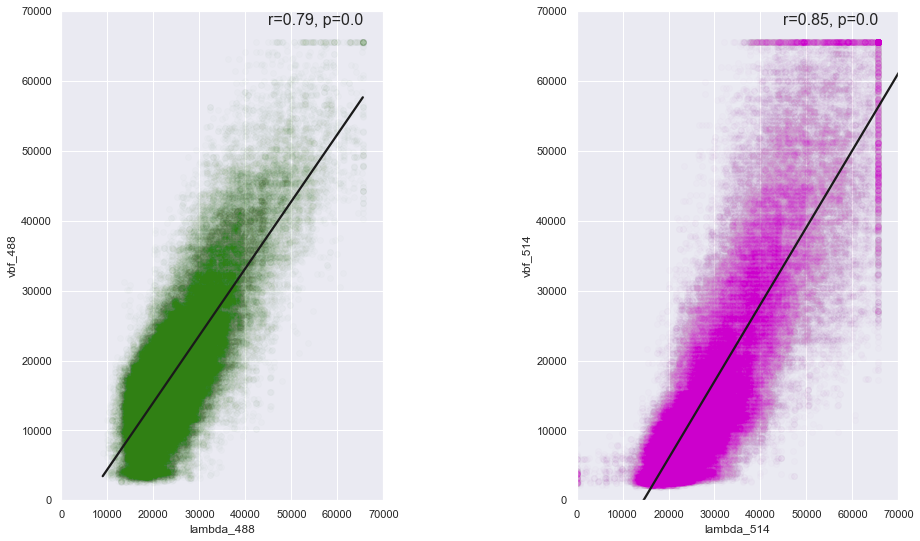

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize =(15,9))
plt.subplots_adjust(wspace = 0.6)
ax1.set_xlim(0,70000)
ax2.set_xlim(0,70000)
ax1.set_ylim(0,70000)
ax2.set_ylim(0,70000)

sns.set_style("whitegrid")
sns.regplot(x='lambda_488', y='vbf_488',
            ci=None, data=ch_488, fit_reg=True, ax = ax1,
            scatter_kws={'alpha':0.01, 'color':"#308014"}, line_kws = {'color' : 'k'} ,truncate = True)

sns.regplot(x='lambda_514', y='vbf_514',
            ci=None, data=ch_514, fit_reg=True, ax = ax2,
            scatter_kws={'alpha':0.01, 'color':"#cc00cc"}, line_kws = {'color' : 'k'} ,truncate = False)

#sns.scatterplot("lambda_488", "vbf_488", data = ch_488, ax=ax1, alpha= 0.3, facecolor="#308014", s = 30)
#sns.scatterplot("lambda_514", "vbf_514", data = ch_514, ax=ax2, alpha= 0.3, facecolor="#cc00cc", s = 30)

text1 = 'r=%s, p=%s' % (a[0], a[1])
text2 = 'r=%s, p=%s' % (b[0], b[1])

ax1.text(45000, 68000, text1, fontsize=16)
ax2.text(45000, 68000, text2, fontsize=16)

plt.savefig("sctplots.png")

## Comparing distribution of pixel intensities in cropped background region

In [11]:
# Cropping bg for both 488 and 514 image

# ROI for 488 channel
x_min_488 = 500
x_max_488 = 700
y_min_488 = 0
y_max_488 = 200

# ROI for 514 channel
x_min_514 = 200
x_max_514 = 400
y_min_514 = 400
y_max_514 = 600

_, bg_lambda_488_cropped_raw = process_image(2, 98, img_lambda_488, 4, x_min_488, x_max_488, y_min_488, y_max_488)
_, bg_lambda_514_cropped_raw  = process_image(2, 98, img_lambda_514, 4, x_min_514, x_max_514, y_min_514, y_max_514)
_, bg_vbf_488_cropped_raw = process_image(2, 98, img_vbf_488, 4, x_min_488, x_max_488, y_min_488, y_max_488)
_, bg_vbf_514_cropped_raw = process_image(2, 98, img_vbf_514, 4, x_min_514, x_max_514, y_min_514, y_max_514)

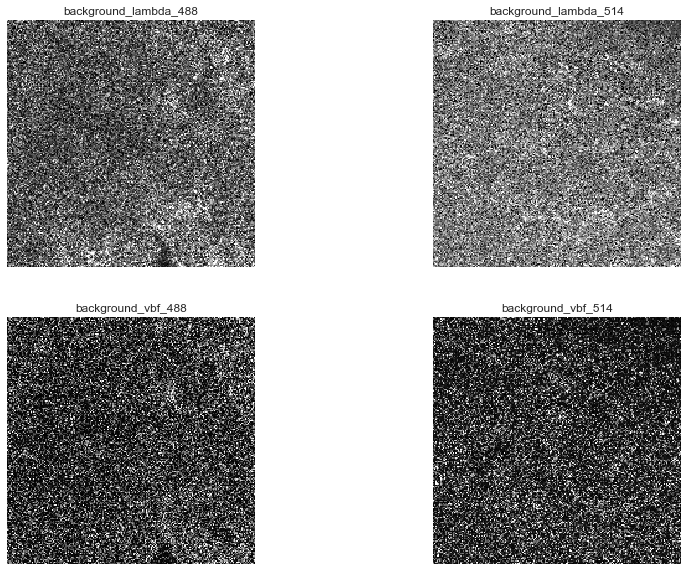

In [12]:
fig, axes = plt.subplots(2,2, figsize=(14, 10))
ax1, ax2, ax3, ax4 = axes.flatten() 

display_image(ax1, bg_lambda_488_cropped_raw, "gray", "background_lambda_488")
display_image(ax2, bg_lambda_514_cropped_raw, "gray", "background_lambda_514")
display_image(ax3, bg_vbf_488_cropped_raw, "gray", "background_vbf_488")
display_image(ax4, bg_vbf_514_cropped_raw, "gray", "background_vbf_514")

plt.savefig("bg_comparison.png")

In [13]:
lambda_488_series = pd.Series(bg_lambda_488_cropped_raw.reshape(bg_lambda_488_cropped_raw.shape[0] * bg_lambda_488_cropped_raw.shape[1]), name='bg_lambda_488')
lambda_514_series = pd.Series(bg_lambda_514_cropped_raw.reshape(bg_lambda_514_cropped_raw.shape[0] * bg_lambda_514_cropped_raw.shape[1]), name='bg_lambda_514')
vbf_488_series = pd.Series(bg_vbf_488_cropped_raw.reshape(bg_vbf_488_cropped_raw.shape[0] * bg_vbf_488_cropped_raw.shape[1]), name='bg_vbf_488')
vbf_514_series = pd.Series(bg_vbf_514_cropped_raw.reshape(bg_vbf_514_cropped_raw.shape[0] * bg_vbf_514_cropped_raw.shape[1]), name='bg_vbf_514')

#display(lambda_488_series.shape == vbf_488_series.shape)
#display(lambda_514_series.shape == vbf_514_series.shape)

df = pd.concat([lambda_488_series, vbf_488_series, lambda_514_series, vbf_514_series], axis=1)
df["id"] = df.index
df = pd.melt(df, id_vars=['id'],var_name='class', value_name='intensity')

## Analysis of background intensity distributions:

Comparing the Alexa fluor 488 background intensities:
* Slightly higher mean intensity value for the VBF channel although the interquartile range is smaller, indicating a lower dispersion 
    
* Lower mean intensity value for the VBF channel with smaller interquartile range. Based on the differences in background pixel intensity distribution, the VBF method appears to yield less background noise in comparison with the spectral imaging method.

# Conclusion

Given the following points when comparing the VBF method to spectral imaging:
1. Significant reduction in imaging acquisition time (by ?) 
2. Relatively high concordance (MOC and Pearson's r) in signal intensities from both methods
3. Less noisy images, at least for the 514 channel

We conclude that we will proceed our analyses using the VBF approach. 

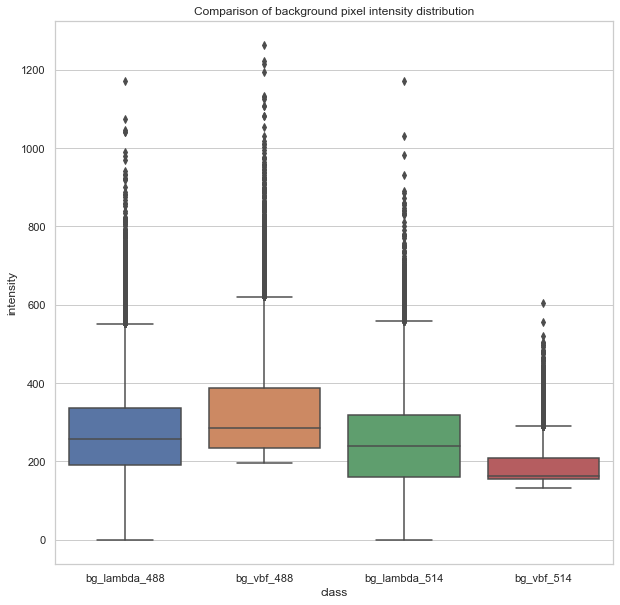

In [14]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(x = 'class', y = 'intensity', data = df, ax=ax).set_title('Comparison of background pixel intensity distribution')
#sns.swarmplot(x="class", y="intensity", data=df, color=".25", ax = ax)
plt.savefig("bg_boxplots.png")